In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter

from game import *
from utils import *
from plots import *
from agents import *
from T4T import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def makePopulation(args):
    rng = np.random.RandomState(seed=args['popSeed'])
    agents = []
    for n in range(args['nAgents']):
        if args["architecture"]=="DQN":
            params = {
                "nActions": 11 if args['player']=='investor' else 31,
                "nNeurons": int(rng.normal(args['nNeurons'], 0.2*args['nNeurons'])),
                "tau": rng.normal(args['tau'], 0.2*args['tau']),
                "alpha": rng.normal(args['alpha'], 0.2*args['alpha']),
                "gamma": rng.normal(args['gamma'], 0.2*args['gamma']),
                "explore": args['explore'],
                "update": args['update'],
                "w_s": args['w_s'],
                "w_i": rng.uniform(0, args['w_i']),
                "w_o": rng.uniform(0, args['w_o']),
            }
            agent = DQN(args['player'], ID="DQN"+str(n), seed=n, nGames=15, **params)
        elif args["architecture"]=="IBL":
            params = {
                "nActions": 11 if args['player']=='investor' else 31,
                "decay": np.max([0, rng.normal(args['decay'], 0.2*args['decay'])]),
                "sigma": rng.normal(args['sigma'], 0.2*args['sigma']),
                "thrA": rng.normal(args['thrA'], 0.2),
                "tau": rng.normal(args['tau'], 0.2*args['tau']),
                "gamma": rng.normal(args['gamma'], 0.2*args['gamma']),
                "explore": args['explore'],
                "update": args['update'],
                "w_s": args['w_s'],
                "w_i": rng.uniform(0, args['w_i']),
                "w_o": rng.uniform(0, args['w_o']),
            }
            agent = IBL(args['player'], ID="IBL"+str(n), seed=n, nGames=15, **params)
        elif args["architecture"]=="NEF":
            agent = NEF(args['player'], ID="NEF"+str(n), seed=n, nGames=15, **params)
        agents.append(agent)
    return agents

In [3]:
def selectLearners(agents, data, thr_slope=0.1, thr_p=0.1):
    IDs = [agent.ID for agent in agents]
    agentsSelected = []
    IDsSelected = []
    for i, ID in enumerate(IDs):
        D1 = data.query('ID==@ID and player=="investor"')
        res1 = scipy.stats.linregress(D1['game'], D1['coins'])
        if res1.slope>thr_slope and res1.pvalue < thr_p:
            agentsSelected.append(agents[i])
            IDsSelected.append(ID)
    print(f'{len(agentsSelected)} agents selected')
    dataSelected = data.query("ID in @IDsSelected")
    return agentsSelected, dataSelected

In [4]:
def addSVO(agents, data):
    dfs = []
    for agent in agents:
        ID, w_o, w_i = agent.ID, agent.w_o, agent.w_i
        D = data.query("ID == @ID").copy()
        D['w_o'] = [w_o for _ in range(D.shape[0])]
        D['w_i'] = [w_i for _ in range(D.shape[0])]
        dfs.append(D)
    labeled = pd.concat(dfs, ignore_index=True)
    return labeled

In [5]:
def addLabel(agents, data, thr):
    IDs = [agent.ID for agent in agents]
    w_is = [agent.w_i for agent in agents]
    w_os = [agent.w_o for agent in agents]
    nProself = 0
    nProsocial = 0
    dfs = []
    for i, ID in enumerate(IDs):
        if w_is[i] + w_os[i] > thr:
            orientation = 'prosocial'
            nProsocial += 1
        else:
            orientation = "proself"
            nProself += 1
        D = data.query("ID == @ID").copy()
        D['orientation'] = [orientation for _ in range(D.shape[0])]
        dfs.append(D)
    labeled = pd.concat(dfs, ignore_index=True)
    print("proself agents:", nProself)
    print("prosocial agents:", nProsocial)
    return labeled

In [6]:
def tTestAndPlot(emp, sim, args, dependent, nFinal=3):
    player = args['player']
    opponent = args['opponent']
    gameFinal = 14 - nFinal
    player2 = 'trustee' if player=='investor' else 'investor'
    emp = emp.query('game>@gameFinal')
    sim = sim.query('game>@gameFinal')
    yticks = ((0, 0.2, 0.4, 0.6, 0.8, 1.0)) if dependent=='generosity' else ((0, 5, 10, 15))

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.violinplot(data=emp, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[0], plot='violinplot')
    annot.configure(test="t-test_ind", loc='inside', verbose=1).apply_test().annotate()
    axes[0].set(xlabel=None, title=f'humans vs {opponent} {player2}', yticks=yticks)

    sns.violinplot(data=sim, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=sim, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[1], plot='violinplot')
    annot.configure(test="t-test_ind", loc='inside', verbose=1).apply_test().annotate()
    axes[1].set(xlabel=None, ylabel=None, title=f'agent vs {opponent} {player2}', yticks=yticks)

    sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.tight_layout()
    fig.savefig(f"plots/{args['architecture']}_vs_{opponent}_{player2}_{dependent}.png", dpi=600)

In [7]:
def empSimOverlap(emp, sim, args):
    if args['optimize_target']=='final':
        gameFinal = args['nGames']-args['nFinal']
        emp = emp.query('game>@gameFinal')
        sim = sim.query('game>@gameFinal')
    empGen = emp['generosity'].to_numpy()
    simGen = sim['generosity'].to_numpy()
    overlap = scipy.stats.ks_2samp(empGen, simGen)[0]
    return overlap

In [8]:
def retestAndPlot(agents, sim, args):
    IDs = [agent.ID for agent in agents]
    for ID in IDs:
        testT4T = sim['t4tSeed'].max()
        S1 = sim.query('ID==@ID & t4tSeed==0')
        S2 = sim.query('ID==@ID & t4tSeed==@testT4T')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 3)))
        sns.histplot(data=S1, x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes[0], color=palette[0])
        ax2 = axes[0].twinx()
        sns.lineplot(data=S1, x='game', y='coins', ax=ax2, color=palette[1])
        axes[0].set(title=f'{ID} vs {args["opponent"]} trustee', xlabel='Game', ylabel='Generosity', yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax2.set(ylabel='Score', yticks=((3,6,9,12,15)))
        sns.histplot(data=S2, x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes[1], color=palette[0])
        ax3 = axes[1].twinx()
        sns.lineplot(data=S2, x='game', y='coins', ax=ax3, color=palette[1])
        axes[1].set(title=f'{ID} vs {args["opponent"]} trustee', xlabel='Game', ylabel='Generosity', yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax3.set(ylabel='Score', yticks=((3,6,9,12,15)))
        plt.tight_layout()
        fig.savefig(f"plots/{ID}_generalize.png", dpi=600)
        plt.close("all")

# vs Greedy Trustee

In [17]:
params = {
    "architecture": "DQN",
    "player": "investor",
    "opponent": "greedy",
    "nAgents": 20,
    'nGames': 15,
    "explore": 'exponential',
    "update": 'Q-learning',
    "w_s": 1,
    "w_o": 0.2,
    "w_i": 0.2,
    "popSeed": 0,
    "nIter": 5,
}
    
params2 = {
    "nNeurons": 70,
    "tau": 17.1,
    "alpha": 0.01,
    "gamma": 0.4
}

args = params | params2

agents = makePopulation(args)
IDs = [agent.ID for agent in agents]

rng = args['popSeed']
dfs = []
for i in range(args['nIter']+1):
    for agent in agents: agent.reinitialize(args['player'])
    df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=i).query("ID in @IDs")
    df['t4tSeed'] = [i for _ in range(df.shape[0])]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [18]:
pop, selected = selectLearners(agents, data)
sim = addLabel(pop, selected, thr=0.2)
sim.to_pickle(f"data/DQN_vs_greedy_trustee_generosity.pkl")

6 agents selected
proself agents: 4
prosocial agents: 2


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.690e-01 t=-7.247e-01


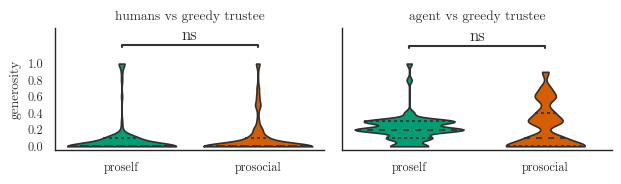

In [19]:
player = args['player']
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')
tTestAndPlot(emp, sim, args, 'generosity')

In [20]:
retestAndPlot(pop, sim, args)